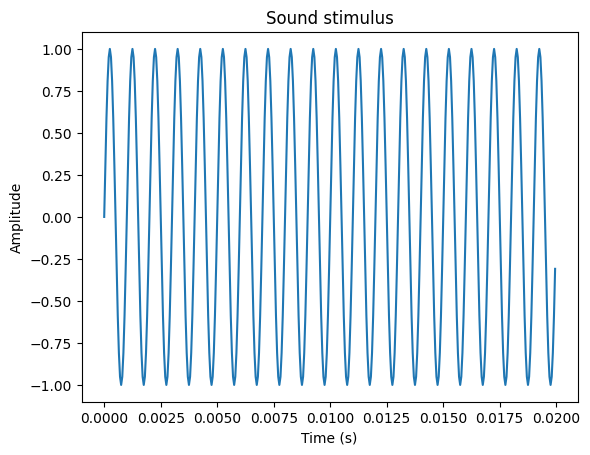

In [13]:
import numpy as np
from scipy.signal import butter, lfilter
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# -----------------------------
# 1. Sound stimulus
# -----------------------------
fs = 20000  # sampling rate (Hz)
T = 0.02  # duration (s)
t = np.arange(0, T, 1 / fs)

freq = 1000  # tone frequency (Hz)
sound = np.sin(2 * np.pi * freq * t)

#plot sound
plt.plot(t, sound)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sound stimulus')
plt.show()

ITD = 116.6 us


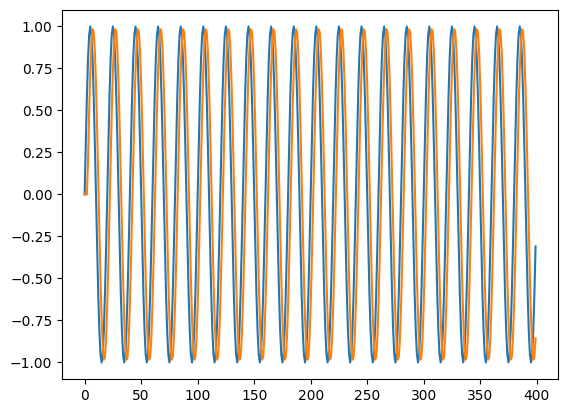

In [14]:
# -----------------------------
# 2. Compute ITD from angle
# -----------------------------
theta_deg = 30.0  # sound angle
theta = np.deg2rad(theta_deg)

d = 0.08  # head width (m)
c = 343.0  # speed of sound (m/s)

itd = (d / c) * np.sin(theta)  # seconds
print(f"ITD = {itd*1e6:.1f} us")


# -----------------------------
# 3. Apply ITD (fractional delay)
# -----------------------------
def fractional_delay(signal, delay, fs):
    t = np.arange(len(signal)) / fs
    f = interp1d(t, signal, bounds_error=False, fill_value=0.0)
    return f(t - delay)


left_signal = sound
right_signal = fractional_delay(sound, itd, fs)

#plot left and right signals
plt.figure()
plt.plot(left_signal)
plt.plot(right_signal)
plt.show()

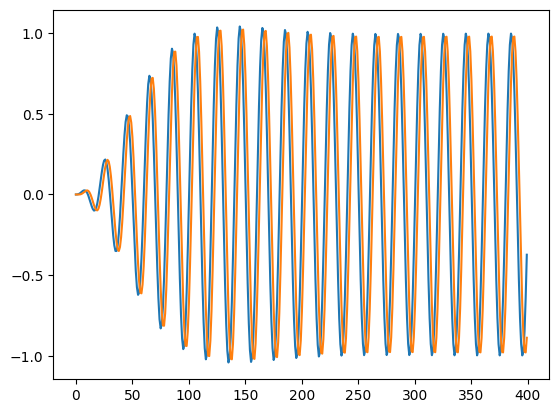

In [15]:
# -----------------------------
# 4. Simple cochlear bandpass filter
# -----------------------------
def bandpass(signal, fs, f_center, bw=200):
    low = (f_center - bw / 2) / (fs / 2)
    high = (f_center + bw / 2) / (fs / 2)
    b, a = butter(2, [low, high], btype="band")
    return lfilter(b, a, signal)


left_filt = bandpass(left_signal, fs, freq)
right_filt = bandpass(right_signal, fs, freq)

# plot filtered signals
plt.figure()
plt.plot(left_filt)
plt.plot(right_filt)
plt.show()

Left spikes:  7
Right spikes: 7
First few spike times (ms):
L: [ 2.08051181  4.09399879  6.13253221  9.14136494 12.1063441 ]
R: [ 2.31729603  5.08613669  7.17077741  9.47539965 12.32895698]


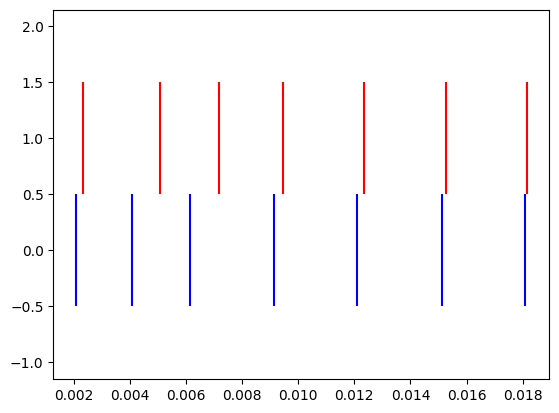

In [18]:

# -----------------------------
# 5. Auditory nerve spike generator
# -----------------------------
def auditory_nerve_spikes(
    signal, fs, threshold=0.3, jitter_std=100e-6, refractory=2e-3
):
    """
    Phase-locking via upward threshold crossings
    """
    spikes = []
    last_spike_time = -np.inf

    for i in range(1, len(signal)):
        if signal[i - 1] < threshold and signal[i] >= threshold:
            spike_time = i / fs
            if spike_time - last_spike_time >= refractory:
                spike_time += np.random.normal(0, jitter_std)
                spikes.append(spike_time)
                last_spike_time = spike_time

    return np.array(spikes)


left_spikes = auditory_nerve_spikes(left_filt, fs)
right_spikes = auditory_nerve_spikes(right_filt, fs)

# -----------------------------
# 6. Inspect results
# -----------------------------
print(f"Left spikes:  {len(left_spikes)}")
print(f"Right spikes: {len(right_spikes)}")

print("First few spike times (ms):")
print("L:", left_spikes[:5] * 1e3)
print("R:", right_spikes[:5] * 1e3)

# raster plot of left and right spikes
plt.figure()
plt.eventplot([left_spikes, right_spikes], colors=["b", "r"])
plt.show()